In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *

import seaborn as sns
sns.set_style('whitegrid')


# Comparison of plot characteristics and digitized deadwood

## Hiidenportti

Read data and do some wrangling.

In [2]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_variables.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
natura_areas = gpd.read_file(field_data_path/'hiidenportti_natura.geojson')

In [3]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
deadwood_cols = dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

Convert `n_dw` (number of deadwood stems per hectare) to signify number of deadwood stems in circular plot with 9m radius.

In [64]:
plot_dw_data.n_dw.describe()

count     71.000000
mean     241.873449
std      174.059660
min        0.000000
25%      137.541309
50%      235.785101
75%      314.380135
max      746.652819
Name: n_dw, dtype: float64

In [65]:
plot_dw_data.v_dw.describe()

count     30.000000
mean      42.100631
std       48.590539
min        0.000000
25%        3.161828
50%       26.292290
75%       60.063217
max      187.149725
Name: v_dw, dtype: float64

In [66]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)

In [5]:
def match_circular_plot(row, plots):
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)

In [6]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [7]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(natura_areas.geometry.contains(row.geometry))
                                                  else 0, axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Plot the relationship between annotated deadwood and field-measured deadwood. The darker a single dot is, the more plots are located in that point.

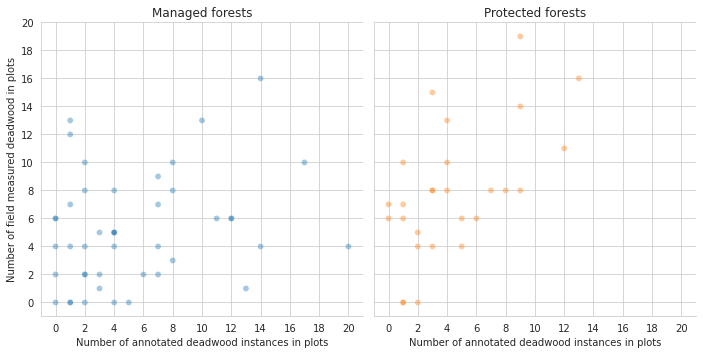

In [8]:
g = sns.relplot(data=plot_dw_data, x='n_dw_ann', y='n_dw_plot', col='conservation', hue='conservation', alpha=.4,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,21,2))
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
g.set_ylabels('Number of field measured deadwood in plots')
g.set_xlabels('Number of annotated deadwood instances in plots')

Read individual tree measurements, and convert `l` from decimeters to meters.

In [9]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

In [10]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

For annotated groundwood, as the annotations can be twisted due to e.g. orthorectification errors, we use the longest side of the smallest rotated rectangle that can be fit around the polygon as a proxy for the trunk length.

Diameter can be approximated with the following approach. For each polygon,

1. Get minimum rotated rectangle and representative point
2. Get the nearest point between those
3. Draw a line from representative point to the nearest point in the minimum rotated rectangle
4. Extend the line so that it goes through the polygon
5. Intersect the resulting line with the polygon. Diameter approximation is the lenght of the intersection.

This is not the same as DBH, but close enough.

In [19]:
from shapely.geometry import LineString, box, Point
from shapely.geometry.polygon import orient
from shapely.ops import nearest_points

def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

def get_three_point_diams(geom):
    """Approximate polygon diameter by creating three lines that intersect the polygon by """
    d = get_len(geom)
    mrr = geom.minimum_rotated_rectangle
    mrr = orient(mrr)
    mrr_x, mrr_y = mrr.exterior.coords.xy
    a_ix = list(mrr_y).index(min(mrr_y))
    b_ix = a_ix + 1 if a_ix < 3 else 0
    c_ix = b_ix + 1 if b_ix < 3 else 0
    d_ix = c_ix + 1 if c_ix < 3 else 0 
    ab = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[b_ix], mrr_y[b_ix])])
    ad = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[d_ix], mrr_y[d_ix])])
    if ab.length > ad.length:
        maxline = ab
        max_ort = LineString([Point(mrr_x[d_ix], mrr_y[d_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])])
    else:
        maxline = ad
        max_ort = LineString([Point(mrr_x[b_ix], mrr_y[b_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])]) 
    bot_a, bot_b = maxline.boundary
    top_a, top_b = max_ort.boundary
    if top_a.y == top_b.y: # horizontal
        line_05 = LineString([Point(min(top_a.x, top_b.x) + 0.05*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.05*d, bot_a.y)])
        line_50 = LineString([Point(min(top_a.x, top_b.x) + 0.5*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.5*d, bot_a.y)])
        line_95 = LineString([Point(max(top_a.x, top_b.x) - 0.05*d, top_b.y),
                              Point(max(bot_a.x, bot_b.x) - 0.05*d, bot_b.y)])
    elif top_a.x == top_b.x: # vertical
        line_05 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.05*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.05*d)])
        line_50 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.5*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.5*d)])
        line_95 = LineString([Point(top_b.x, max(top_a.y,  top_b.y) - 0.05*d), 
                              Point(bot_b.x, max(bot_a.y,  bot_b.y) - 0.05*d)])
    else: # we do geometry, solve <x,y> = <x_1,y_1> + t<1,m>
        k = (bot_b.y - bot_a.y) / (bot_b.x - bot_a.x)
        mul = 1 if k > 0 else -1
        top_x_05 = top_a.x + mul * np.sqrt(((0.05*d)**2)/(1+k**2))
        top_x_50 = top_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        top_x_95 = top_a.x + mul * np.sqrt(((0.95*d)**2)/(1+k**2))
        top_y_05 = top_a.y + np.sqrt(((0.05*d*k)**2)/(1+k**2))
        top_y_50 = top_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        top_y_95 = top_a.y + np.sqrt(((0.95*d*k)**2)/(1+k**2))
        bot_x_05 = bot_a.x + mul * np.sqrt(((0.05*d)**2)/(1+k**2))
        bot_x_50 = bot_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        bot_x_95 = bot_a.x + mul * np.sqrt(((0.95*d)**2)/(1+k**2))
        bot_y_05 = bot_a.y + np.sqrt(((0.05*d*k)**2)/(1+k**2))
        bot_y_50 = bot_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        bot_y_95 = bot_a.y + np.sqrt(((0.95*d*k)**2)/(1+k**2))
        line_05 = LineString([Point(top_x_05, top_y_05), Point(bot_x_05, bot_y_05)])
        line_50 = LineString([Point(top_x_50, top_y_50), Point(bot_x_50, bot_y_50)])
        line_95 = LineString([Point(top_x_95, top_y_95), Point(bot_x_95, bot_y_95)])
        
    return line_05.intersection(geom).length, line_50.intersection(geom).length, line_95.intersection(geom).length

def cut_cone_volume(geom):
    """Estimate the volume for the polygon by assuming that it is constructed from two 
    truncated right circular truncated cones.
    """
    h = get_len(geom)/2
    d_05, d_50, d_95 = get_three_point_diams(geom)
    r_05 = d_05/2
    r_50 = d_50/2
    r_95 = d_95/2
    V_1 = (np.pi*h*(r_05**2 + r_05*r_50 + r_50**2))/3
    V_2 = (np.pi*h*(r_95**2 + r_95*r_50 + r_50**2))/3
    return V_1 + V_2

def get_len_in_plot(geom, circles):
    "Use the longest side of the minimum rotated rectangle around a polygon as the proxy for trunk length"
    matching_circle = circles[circles.intersects(geom)].iloc[0].geometry
    geom = copy(geom.intersection(matching_circle))
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

In [20]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account.

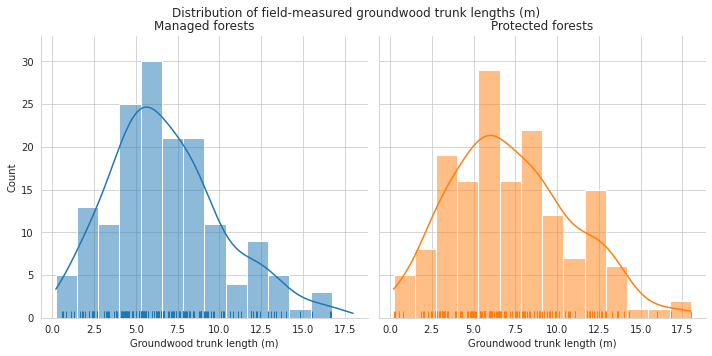

In [21]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

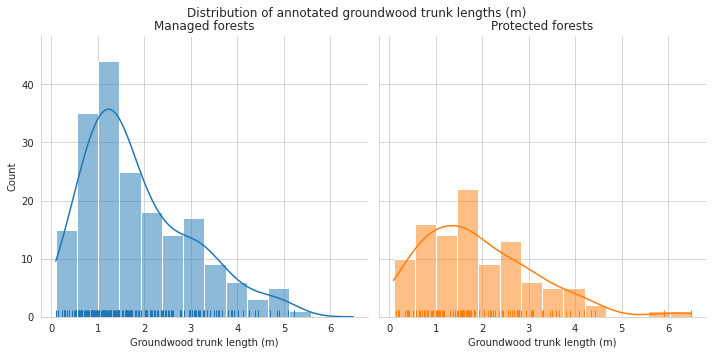

In [22]:
g = sns.displot(data=anns_in_plots[anns_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot.

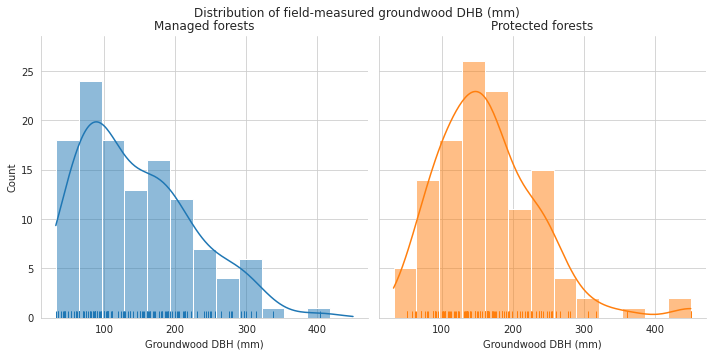

In [23]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

<ipython-input-19-3eeb298613c7>:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  bot_a, bot_b = maxline.boundary
<ipython-input-19-3eeb298613c7>:30: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  top_a, top_b = max_ort.boundary


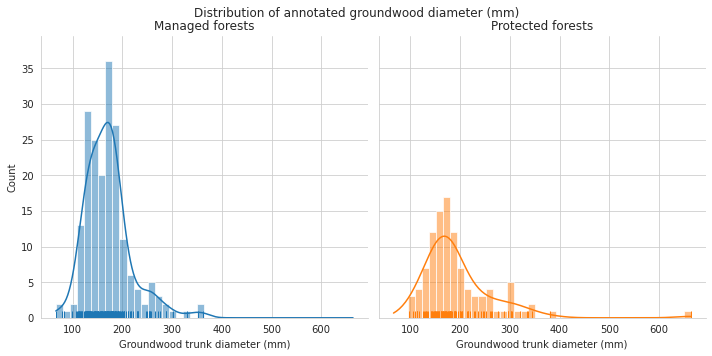

In [24]:
anns_in_plots['diam'] = anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=anns_in_plots[(anns_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

In [26]:
plot_dw_data['n_dw_stand_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                                (tree_data.tree_class == 3)]),
                                                      axis=1)
plot_dw_data['n_dw_fall_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                               ((tree_data.tree_class == 4)|
                                                                                (tree_data.tree_class == 5))]),
                                                     axis=1)
plot_dw_data['n_dw_stand_ann'] = plot_dw_data.apply(lambda row: len(anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                                  (anns_in_plots.layer != 'groundwood')]),
                                                    axis=1)
plot_dw_data['n_dw_fall_ann'] = plot_dw_data.apply(lambda row: len(anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                                 (anns_in_plots.layer == 'groundwood')]),
                                                    axis=1)

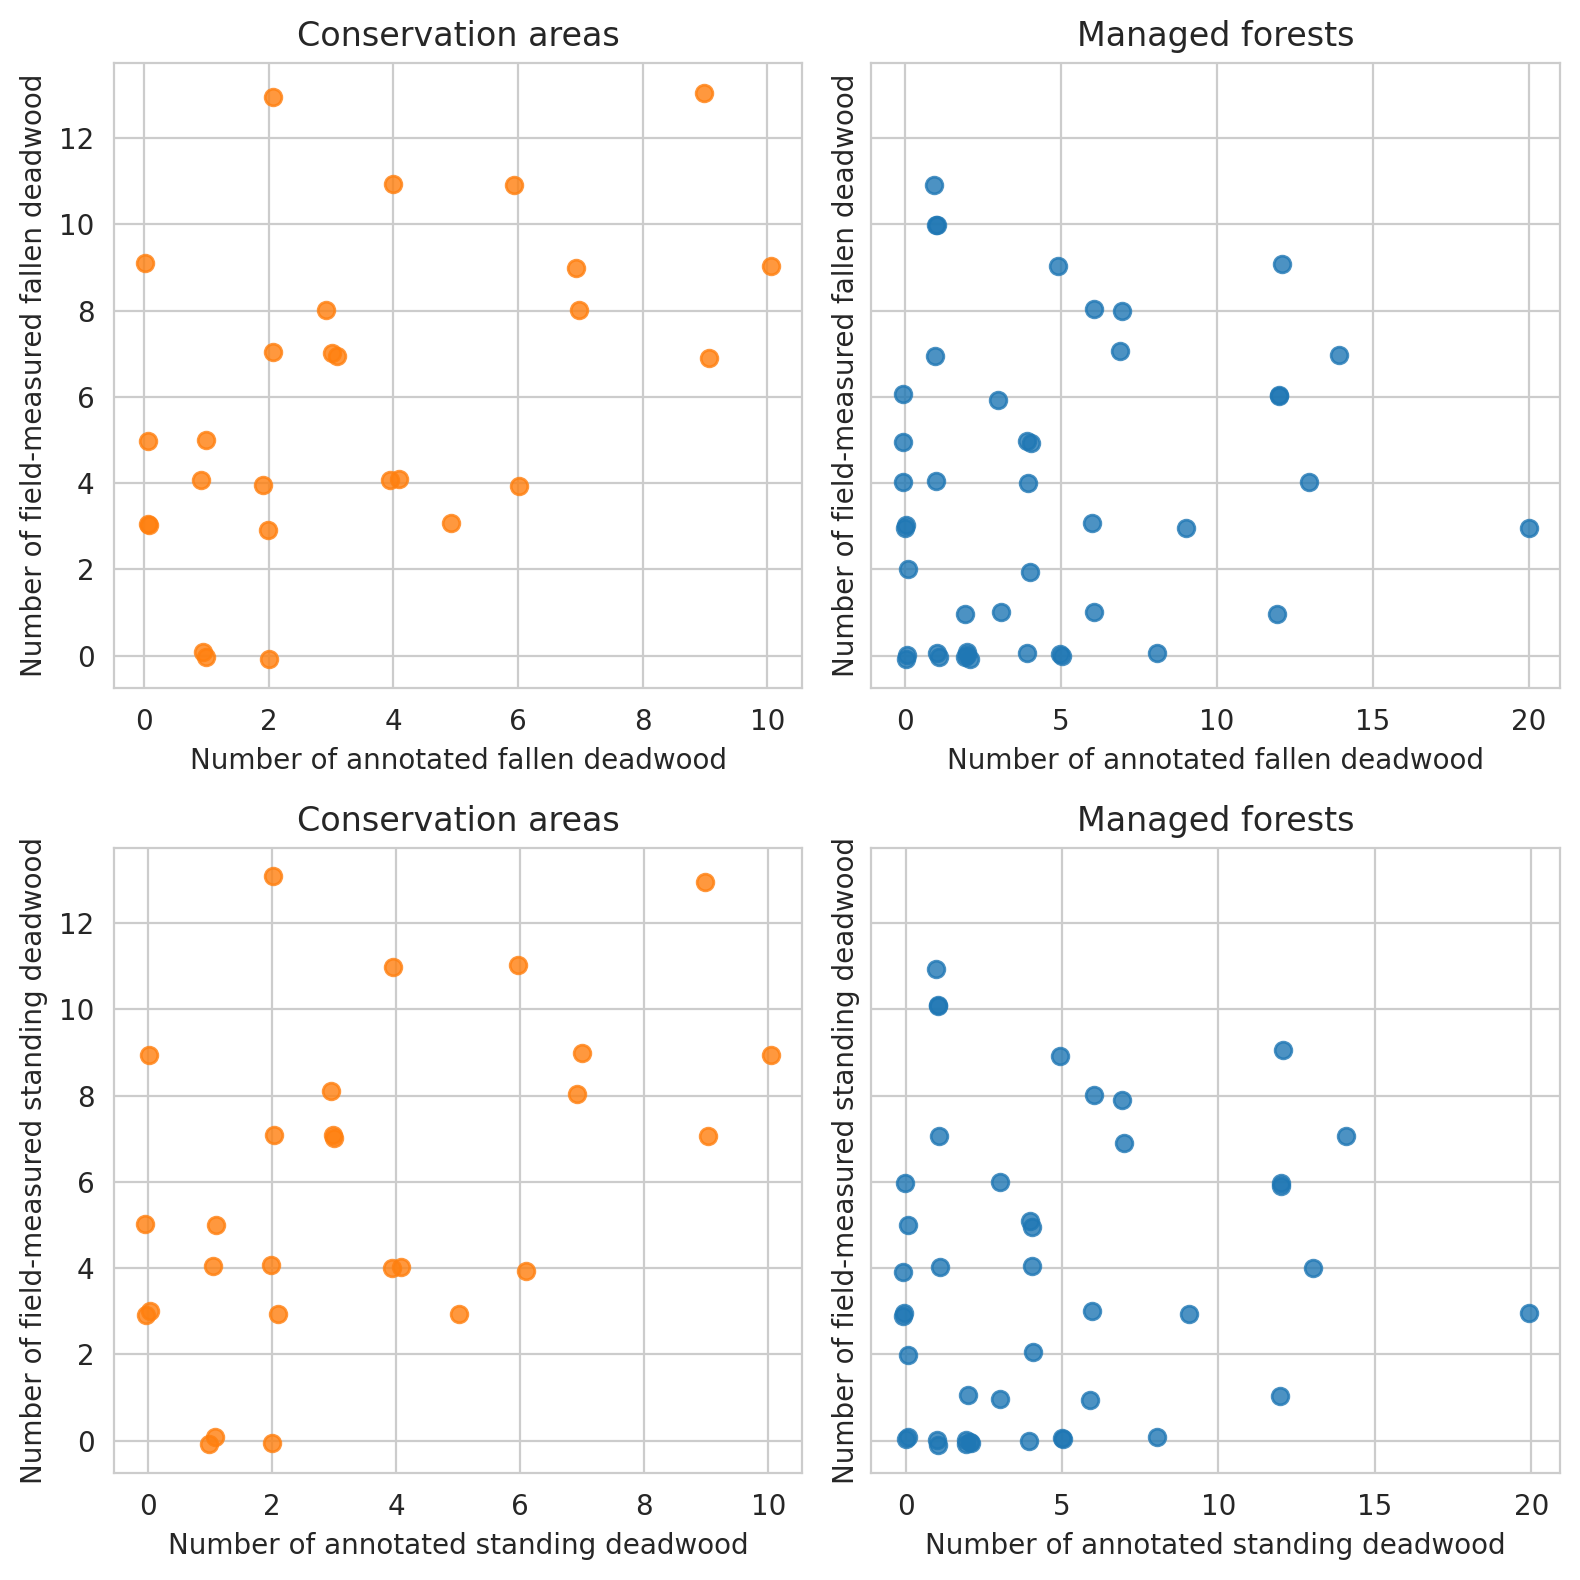

In [49]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=False)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('Number of field-measured fallen deadwood')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')

sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('Number of field-measured standing deadwood')
plt.tight_layout()

Plot the total lengths of groundwood located within a single field plot.

In [28]:
plot_dw_data['l_gw_field'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id == row.id) &
                                                                      (tree_data.tree_class == 4)].l.sum()
                                              , axis=1)
plot_dw_data['l_gw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

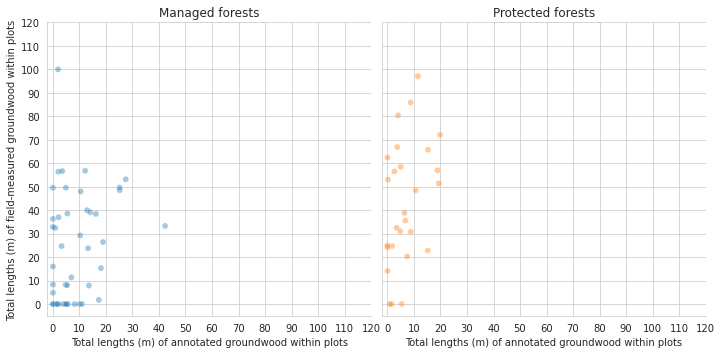

In [51]:
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_gw_field', col='conservation', hue='conservation', alpha=.4,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,121,10))
g.axes[0,0].set_xticks(range(0,121,10))
g.axes[0,1].set_xticks(range(0,121,10))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

## Sudenpesänkangas

Read data and do some wrangling.

In [33]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_plots = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_natura = gpd.read_file(evo_fd_path/'sudenpesankangas_natura.geojson')
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

In [34]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

In [35]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [36]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(evo_natura.geometry.contains(row.geometry))
                                                        else 0, axis=1)

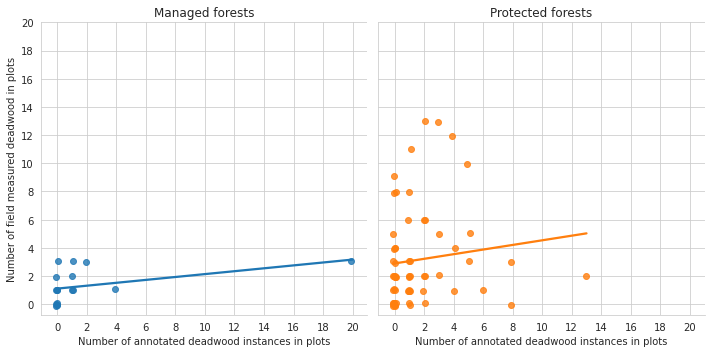

In [37]:
g = sns.lmplot(data=evo_plots, x='n_dw_ann', y='n_dw_plot', col='conservation', hue='conservation',
                legend=False, x_jitter=0.1, y_jitter=0.1, ci=None)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Number of field measured deadwood in plots')
g.set_xlabels('Number of annotated deadwood instances in plots')
g.axes[0,0].set_yticks(range(0,21,2))
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
plt.show()

In [54]:
evo_plots['n_dw_fall'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.puuluo == 4) & (evo_field_data.plotid==row.id)]), axis=1)
evo_plots['n_dw_standing'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.puuluo == 3) & (evo_field_data.plotid==row.id)]), axis=1)
evo_plots['n_dw_both'] = evo_plots.n_dw_fallen + evo_plots.n_dw_standing

In [55]:
evo_plots['n_dw_stand_field'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.plotid == row.id) &
                                                                               (evo_field_data.puuluo == 3)]),
                                               axis=1)
evo_plots['n_dw_fall_field'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.plotid == row.id) &
                                                                              ((evo_field_data.puuluo == 4)|
                                                                               (evo_field_data.puuluo == 5))]),
                                               axis=1)
evo_plots['n_dw_stand_ann'] = evo_plots.apply(lambda row: len(evo_anns[(evo_anns.plot_id == row.id) &
                                                                       (evo_anns.label != 'groundwood')]),
                                              axis=1)
evo_plots['n_dw_fall_ann'] = evo_plots.apply(lambda row: len(evo_anns[(evo_anns.plot_id == row.id) &
                                                                      (evo_anns.label == 'groundwood')]),
                                             axis=1)

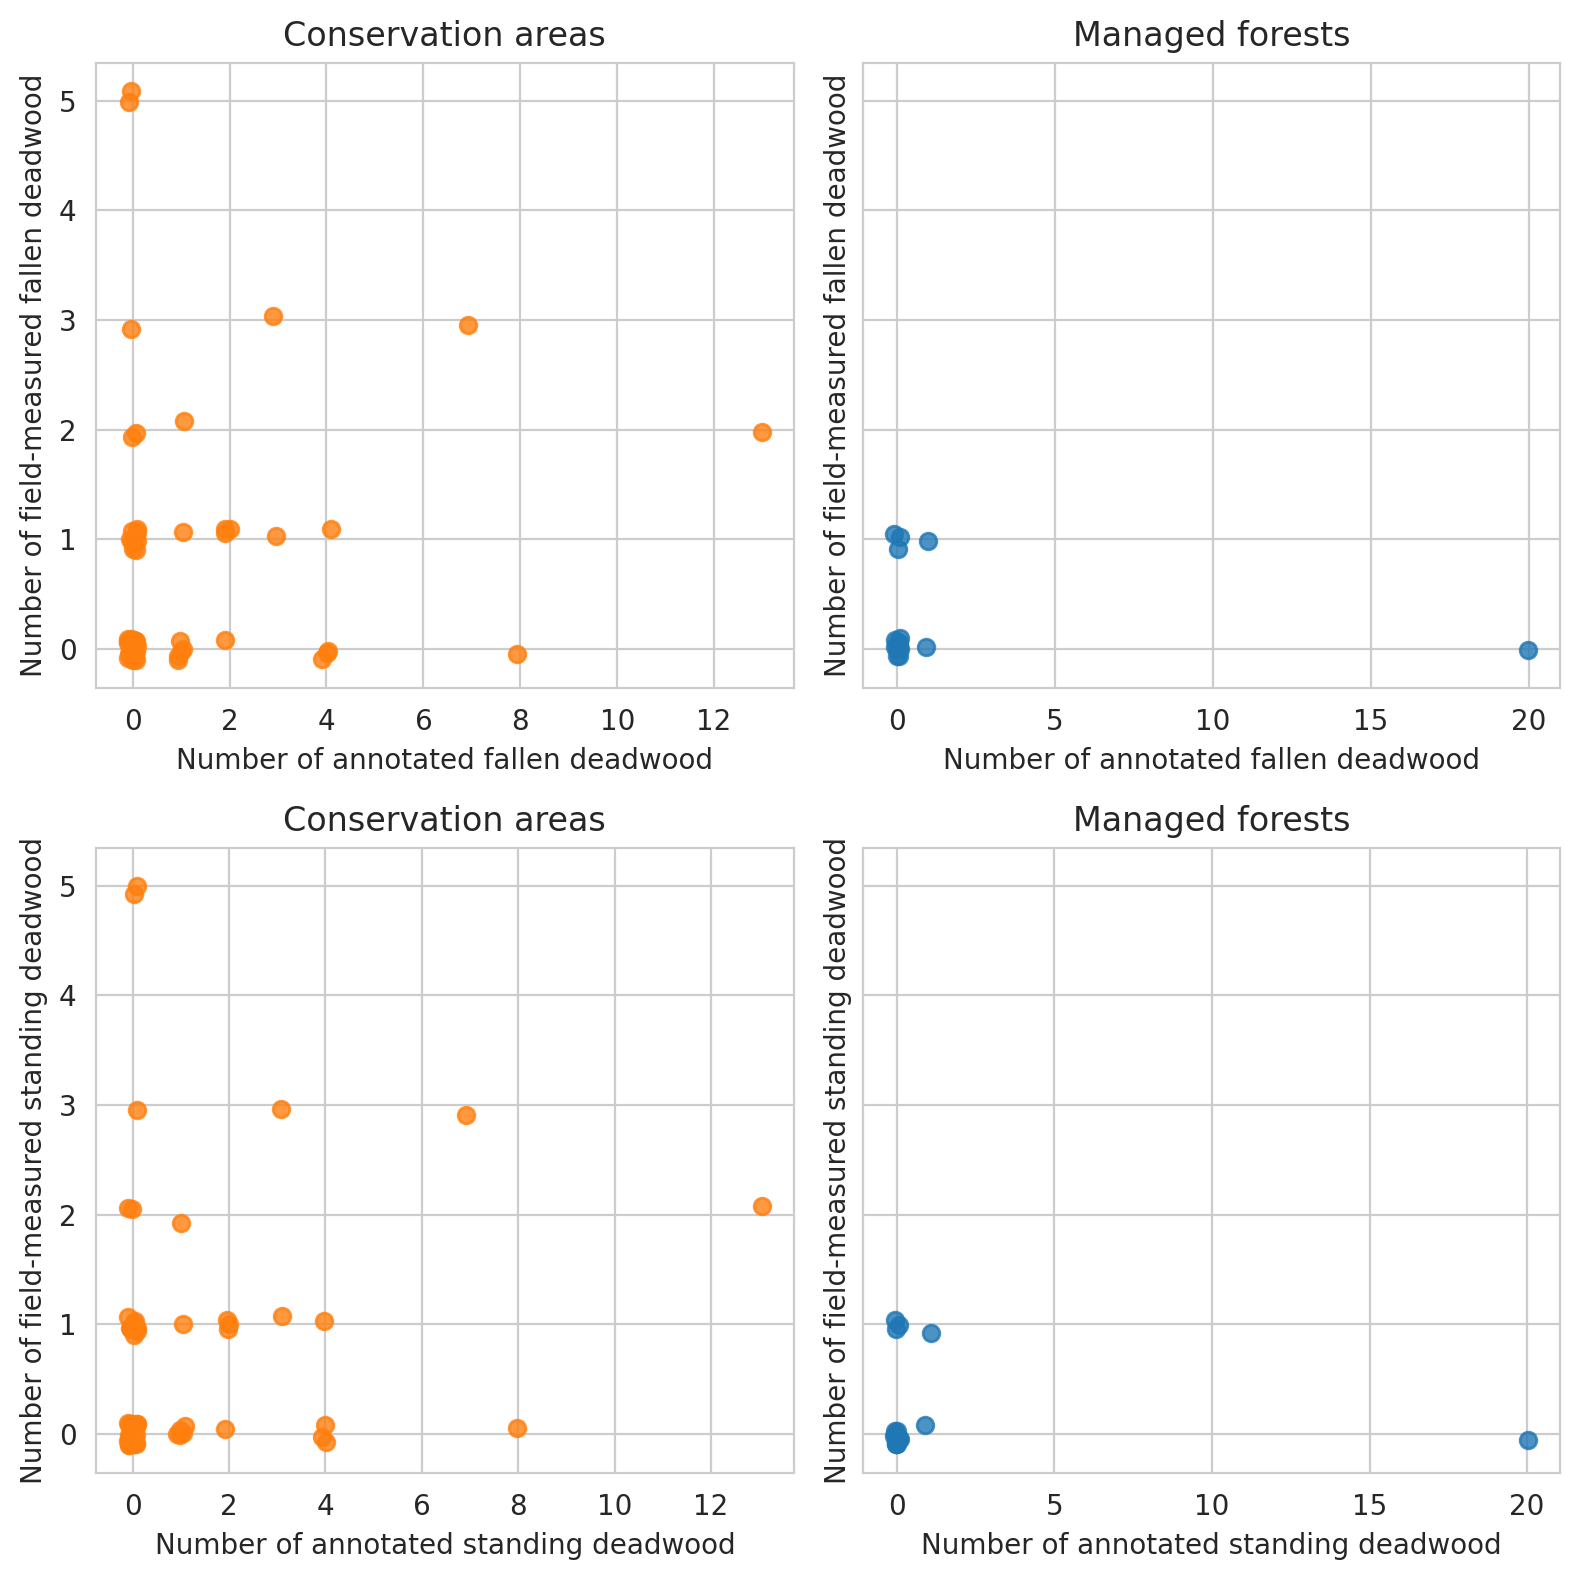

In [56]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=False)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('Number of field-measured fallen deadwood')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')

sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('Number of field-measured standing deadwood')
plt.tight_layout()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [57]:
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

In [58]:
evo_field_data[evo_field_data.puuluo==4].lapimitta_mm.describe()

count     47.000000
mean     129.170213
std      112.932900
min       45.000000
25%       61.000000
50%       84.000000
75%      140.000000
max      552.000000
Name: lapimitta_mm, dtype: float64

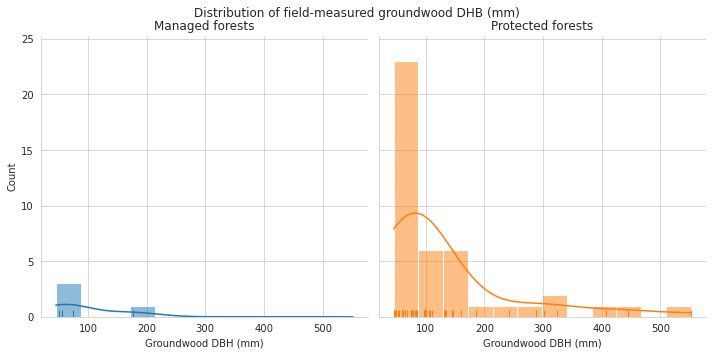

In [59]:
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

<ipython-input-19-3eeb298613c7>:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  bot_a, bot_b = maxline.boundary
<ipython-input-19-3eeb298613c7>:30: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  top_a, top_b = max_ort.boundary


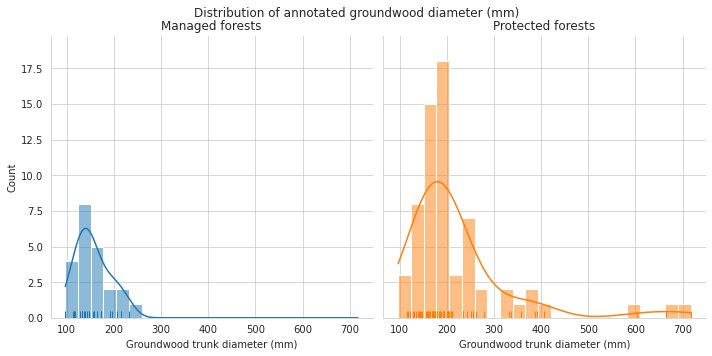

In [60]:
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()